In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import time
import itertools
from IPython import display
import imageio

In [0]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, d=128):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=noise_dim, 
                                           out_channels=d*8, 
                                           kernel_size=4, 
                                           stride=1, 
                                           padding=0,
                                           bias=False),
                        nn.BatchNorm2d(d*8),
                        nn.LeakyReLU()
        )
        self.block2 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d*8, 
                                           out_channels=d*4, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1,
                                           bias=False),
                        nn.BatchNorm2d(d*4),
                        nn.LeakyReLU()
        ) 
        self.block3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d*4, 
                                           out_channels=d*2, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1,
                                           bias=False),
                        nn.BatchNorm2d(d*2),
                        nn.LeakyReLU()
        )
        self.block4 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d*2, 
                                           out_channels=d, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1,
                                           bias=False),
                        nn.BatchNorm2d(d),
                        nn.LeakyReLU()
        )
        self.block5 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d, 
                                           out_channels=1, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1),
                        nn.Tanh()
        )

    # weight initialzation
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        return out
    
d = 128
NOISE_DIM = 100
G = Generator(NOISE_DIM, d).to(device)
G.weight_init(mean=0.0, std=0.02)
G

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(neg

In [5]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.block1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=d, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block2 = nn.Sequential(
                        nn.Conv2d(in_channels=d, out_channels=d*2, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(d*2),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block3 = nn.Sequential(
                        nn.Conv2d(in_channels=d*2, out_channels=d*4, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(d*4),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block4 = nn.Sequential(
                        nn.Conv2d(in_channels=d*4, out_channels=d*8, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(d*8),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block5 = nn.Sequential(
                        nn.Conv2d(in_channels=d*8, out_channels=1, kernel_size=4, stride=1, padding=0),
                        nn.Sigmoid()
            )

    # weight initialzation
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        return out

d = 128      
D = Discriminator(d).to(device)
D.weight_init(mean=0.0, std=0.02)
D

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout2d(p=0.3)
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.3)
  )
  (block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.3)
  )
  (block4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Drop

In [0]:
with torch.no_grad():
    fixed_noise = torch.randn((5 * 5, NOISE_DIM)).view(-1, NOISE_DIM, 1, 1).to(device)    # fixed noise
def show_result(num_epoch, show=False, save=False, path='result.png', fixedNoise=False):
    with torch.no_grad():
        noise = torch.randn((5*5, NOISE_DIM)).view(-1, NOISE_DIM, 1, 1).to(device)
    G.eval()
    if fixedNoise:
        test_images = G(fixed_noise)
    else:
        test_images = G(noise)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [0]:
def train_history(hist, show=False, save=False, path='train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='discriminator loss')
    plt.plot(x, y2, label='generator loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [0]:
BATCH_SIZE = 128
lr = 0.0002
NUM_EPOCHS = 20

img_size = (64,64)
transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ])
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('data', train=True, download=True, transform=transform),
                batch_size=BATCH_SIZE, shuffle=True)

In [0]:
# results save folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Images_random'):
    os.mkdir('MNIST_DCGAN_results/Images_random')
if not os.path.isdir('MNIST_DCGAN_results/Images_fixed'):
    os.mkdir('MNIST_DCGAN_results/Images_fixed')

In [0]:
loss = nn.BCELoss()

In [0]:
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [0]:
def trainDiscriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    D_real_output = D(real_data).squeeze()
    smoothing = torch.FloatTensor(1).uniform_(0, 0.3).item()
    ones_target = torch.ones(mini_batch)*(1-smoothing) #one-sided label smoothing
    ones_target = ones_target.to(device)
    D_real_loss = loss(D_real_output, ones_target)

    D_fake_output = D(fake_data).squeeze()
    zeros_target = torch.zeros(mini_batch).to(device)
    D_fake_loss = loss(D_fake_output, zeros_target)

    D_train_loss = D_real_loss + D_fake_loss

    D_train_loss.backward()
    optimizer.step()
    
    return D_train_loss

In [0]:
def trainGenerator(optimizer, fake_data):
    optimizer.zero_grad()
    
    D_fake_output = D(fake_data).squeeze()
    ones_target = torch.ones(mini_batch).to(device)
    G_train_loss = loss(D_fake_output, ones_target)
    G_train_loss.backward()
    optimizer.step()
    
    return G_train_loss

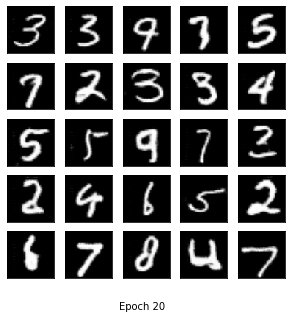

20/20 - time: 13.488096 minutes, discriminator_loss: 0.495482, generator_loss: 3.489929
CPU times: user 2h 28min 48s, sys: 2h 1min 45s, total: 4h 30min 34s
Wall time: 4h 30min 39s


In [18]:
%%time
PATH = './models_param.pth'
train_hist = {'D_losses': [],
              'G_losses': [],
             }
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    D.train()
    G.train()
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for samples, _ in train_loader:
        mini_batch = samples.size(0)
        samples = samples.to(device)
        
        # train discriminator D
        noise = torch.randn((mini_batch, NOISE_DIM), requires_grad=True).view(-1, NOISE_DIM, 1, 1).to(device)
        fake_data = G(noise)        
        D_train_loss = trainDiscriminator(D_optimizer, samples, fake_data)
        D_losses.append(D_train_loss.data.item())

        # train generator G
        noise = torch.randn((mini_batch, NOISE_DIM), requires_grad=True).view(-1, NOISE_DIM, 1, 1).to(device)
        fake_data = G(noise)
        G_train_loss = trainGenerator(G_optimizer, fake_data)
        G_losses.append(G_train_loss.data.item())


    epoch_end_time = time.time()
    per_epoch_time = (epoch_end_time - epoch_start_time)/60 #in minutes


    
    image_random = 'MNIST_DCGAN_results/Images_random/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    image_fixed = 'MNIST_DCGAN_results/Images_fixed/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    display.clear_output(wait=True)
    show_result((epoch+1), save=True, path=image_random, fixedNoise=False)
    show_result((epoch+1), show=True, save=True, path=image_fixed, fixedNoise=True)
    
    printString = '{}/{} - time: {:3f} minutes, discriminator_loss: {:4f}, generator_loss: {:4f}'
    print(printString.format(epoch+1, 
                             NUM_EPOCHS, 
                             per_epoch_time, 
                             torch.mean(torch.FloatTensor(D_losses)),
                             torch.mean(torch.FloatTensor(G_losses))
                            )
         )
    
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    
    # save models' weights
    torch.save({
                'generator_param': G.state_dict(),
                'discriminator_param': D.state_dict(),
            }, PATH)

end_time = time.time()
total_time = (end_time - start_time)/60 # in minutes


In [19]:
checkpoint = torch.load(PATH)
G.load_state_dict(checkpoint['generator_param'])
G.eval()
D.load_state_dict(checkpoint['discriminator_param'])
D.eval()

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout2d(p=0.3)
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.3)
  )
  (block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.3)
  )
  (block4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Drop

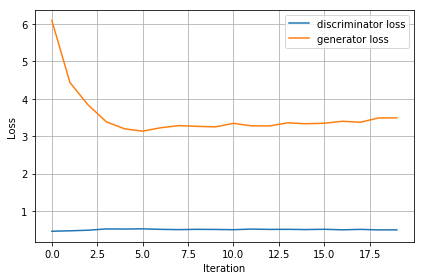

In [22]:
train_history(train_hist, show=True, save=True, path='MNIST_DCGAN_results/MNIST_DCGAN_train_hist.png')

# create gif for generator's outputs given a fixed noise as the input
images = []
for epoch in range(NUM_EPOCHS):
    img_name = 'MNIST_DCGAN_results/Images_fixed/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_DCGAN_results/generation_animation.gif', images, fps=5)

In [25]:
# this is a hack to display the gif inside the notebook
os.system('cp MNIST_DCGAN_results/generation_animation.gif MNIST_DCGAN_results/generation_animation.gif.png')

0

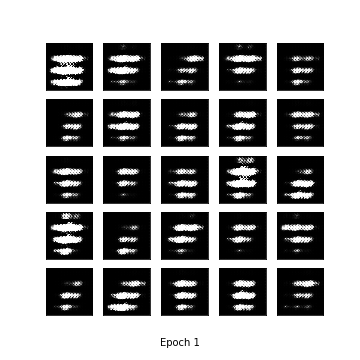

In [26]:
display.Image(filename="MNIST_DCGAN_results/generation_animation.gif.png")